<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Evaluating an Agent</h1>



## Install Dependencies, Import Libraries, Set API Keys

In [1]:
!pip install -q openai arize-phoenix openinference-instrumentation-openai python-dotenv duckdb

In [2]:
import dotenv

dotenv.load_dotenv()

from openai import OpenAI
from phoenix.otel import register
from opentelemetry.trace import StatusCode
from openinference.instrumentation.openai import OpenAIInstrumentor
from openinference.instrumentation import using_prompt_template
from openinference.semconv.trace import SpanAttributes
from opentelemetry import trace
import duckdb
import json
import os
from getpass import getpass
import pandas as pd
from pydantic import BaseModel, Field
from IPython.display import Markdown
from tqdm import tqdm


In [3]:
if os.getenv("OPENAI_API_KEY") is None:
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

if os.getenv("PHOENIX_CLIENT_HEADERS") is None:
    os.environ["PHOENIX_CLIENT_HEADERS"] = f'api_key={getpass("Enter your Phoenix api key: ")}'
    
os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "https://app.phoenix.arize.com/"

client = OpenAI()
model = "gpt-4o-mini"
project_name = "github-1-15-2025-live"

In [ ]:
# Register Phoenix for monitoring
tracer_provider = register(
    project_name=project_name
)

tracer = tracer_provider.get_tracer(__name__)

# Initialize OpenAI instrumentation
OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)

## Prepare dataset

In [4]:
store_sales_df = pd.read_parquet("https://storage.googleapis.com/arize-phoenix-assets/datasets/unstructured/llm/llama-index/Store_Sales_Price_Elasticity_Promotions_Data.parquet")
store_sales_df.head()

,Store_Number,SKU_Coded,Product_Class_Code,Sold_Date,Qty_Sold,Total_Sale_Value,On_Promo
0,1320,6172800,22875,2021-11-02,3,56.849998,0
1,2310,6172800,22875,2021-11-03,1,18.950001,0
2,3080,6172800,22875,2021-11-03,1,18.950001,0
3,2310,6172800,22875,2021-11-06,1,18.950001,0
4,4840,6172800,22875,2021-11-07,1,18.950001,0


## Define the tools

### Tool 1: Database Lookup

In [5]:
SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""

def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, columns=columns, table_name=table_name)

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    return response.choices[0].message.content

def lookup_sales_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:
        table_name = "sales"
        # Read the parquet file into a DuckDB table
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM store_sales_df")
        
        sql_query = generate_sql_query(prompt, store_sales_df.columns, table_name)
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        
        with tracer.start_as_current_span("execute_sql_query") as span:
            span.set_attribute(SpanAttributes.OPENINFERENCE_SPAN_KIND, "CHAIN")
            span.set_attribute(SpanAttributes.INPUT_VALUE, sql_query)
            span.set_attribute(SpanAttributes.INPUT_MIME_TYPE, "application/json")
            
            # Execute the SQL query
            result = duckdb.sql(sql_query).df()
            span.set_attribute(SpanAttributes.OUTPUT_VALUE, str(result))
            span.set_status(StatusCode.OK)
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

In [6]:
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
example_data

'    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo\n0           1320    6173050               22875 2021-11-01         1          4.990000         0\n1           1320    6174250               22875 2021-11-01         1          0.890000         0\n2           1320    6176200               22975 2021-11-01         2         99.980003         0\n3           1320    6176800               22800 2021-11-01         1         14.970000         0\n4           1320    6177250               22975 2021-11-01         1          6.890000         0\n5           1320    6177300               22800 2021-11-01         1          9.990000         0\n6           1320    6177350               22800 2021-11-01         2         16.980000         0\n7           1320    6177700               22875 2021-11-01         1          3.190000         0\n8           1320    6178000               22875 2021-11-01         2          6.380000         0\n9           1320   

### Tool 2: Data Visualization

In [7]:
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration
    
    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Dictionary containing line chart configuration
    """
    prompt = f"""Generate a chart configuration based on this data: {data}
    The goal is to show: {visualization_goal}"""
    
    response = client.beta.chat.completions.parse(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        response_format=VisualizationConfig,
    )
    
    try:
        # Extract axis and title info from response
        content = response.choices[0].message.content
        
        # Return structured chart config
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }
        
def create_chart(config: VisualizationConfig) -> str:
    """Create a chart based on the configuration"""
    prompt = f"""Write python code to create a chart based on the following configuration.
    Only return the code, no other text.
    config: {config}"""
    
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
    )
    
    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()
    
    return code

def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

In [8]:
code = generate_visualization(example_data, "A line chart of sales over each day in november.")

### Tool 3: Data Analysis

In [9]:
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    # Construct prompt based on analysis type and data subset
    prompt = f"""Analyze the following data: {data}
    Your job is to answer the following question: {prompt}"""
    
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
    )
    
    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

In [10]:
analysis = analyze_sales_data("What is the most popular product SKU?", example_data)
analysis


"To determine the most popular product SKU from the data provided, we can look at the `Qty_Sold` column across all entries and identify which SKU has the highest total quantity sold.\n\nHere’s a summary of the steps to find the most popular SKU:\n\n1. **Aggregate the Quantity Sold by SKU**: We will group the data by the `SKU_Coded` and sum the `Qty_Sold` for each SKU.\n2. **Identify the SKU with the Maximum Quantity Sold**: From the aggregated data, we will find the SKU with the highest total quantity.\n\nLet's perform this analysis based on the data you provided:\n\nFirst, we can summarize the quantity sold for each SKU:\n\n| SKU_Coded | Total_Qty_Sold |\n|-----------|----------------|\n| 6173050   | 1              |\n| 6174250   | 1              |\n| 6176200   | 2              |\n| 6176800   | 1              |\n| 6177250   | 1              |\n| 6177300   | 1              |\n| 6177350   | 2              |\n| 6177700   | 1              |\n| 6178000   | 2              |\n| 6178250   | 1

### Tool 4: Run Python Code

In [11]:
def run_python_code(code: str) -> str:
    """Execute Python code in a restricted environment"""
    # Create restricted globals/locals dictionaries with plotting libraries
    restricted_globals = {
        '__builtins__': {
            'print': print,
            'len': len,
            'range': range,
            'sum': sum,
            'min': min,
            'max': max,
            'int': int, 
            'float': float,
            'str': str,
            'list': list,
            'dict': dict,
            'tuple': tuple,
            'set': set,
            'round': round,
            '__import__': __import__,
            'json': __import__('json')
        },
        'plt': __import__('matplotlib.pyplot'),
        'pd': __import__('pandas'),
        'np': __import__('numpy'),
        'sns': __import__('seaborn')
    }
    
    try:
        # Execute code in restricted environment
        exec_locals = {}
        exec(code, restricted_globals, exec_locals)
        
        # Capture any printed output or return the plot
        output = exec_locals.get('__builtins__', {}).get('_', '')
        if 'plt' in exec_locals:
            return exec_locals['plt']
        
        # Try to parse output as JSON before returning
        return "Code executed successfully"
        
    except Exception as e:
        return f"Error executing code: {str(e)}"

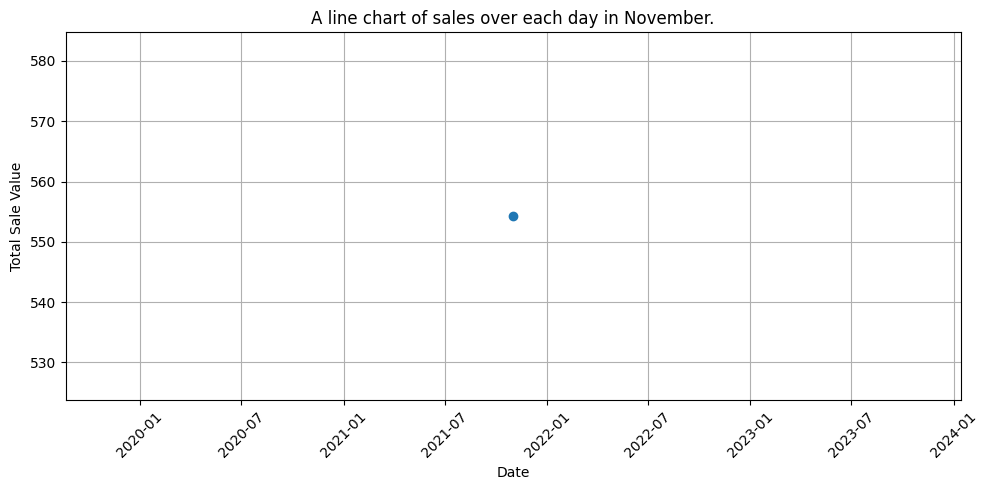

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/phoenix/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [12]:
run_python_code(code)

### Tool Schema:

In [13]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_sales_data",
            "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data", 
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object", 
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "run_python_code",
            "description": "Run Python code in a restricted environment",
            "parameters": {
                "type": "object",
                "properties": {
                    "code": {"type": "string", "description": "The Python code to run"}
                },
                "required": ["code"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data, 
    "generate_visualization": generate_visualization,
    "run_python_code": run_python_code
}


## Agent logic

In [14]:
def handle_tool_calls(tool_calls, messages):
    for tool_call in tool_calls:
        with tracer.start_as_current_span(f"tool_call_{tool_call.function.name}") as span:
            span.set_attribute(SpanAttributes.OPENINFERENCE_SPAN_KIND, "TOOL")
            span.set_attribute(SpanAttributes.INPUT_VALUE, str(tool_call))
            span.set_attribute(SpanAttributes.INPUT_MIME_TYPE, "application/json")
            span.set_attribute(SpanAttributes.TOOL_NAME, tool_call.function.name)
            span.set_attribute(SpanAttributes.TOOL_PARAMETERS, str(tool_call.function.arguments))
            
            function = tool_implementations[tool_call.function.name]
            function_args = json.loads(tool_call.function.arguments)
            result = function(**function_args)
            
            span.set_attribute(SpanAttributes.OUTPUT_VALUE, str(result))
            
            messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.id})
    return messages


In [15]:
def start_main_span(messages):
    print("Starting main span with messages:", messages)
    
    with tracer.start_as_current_span("AgentRun") as span:
        span.set_attribute(SpanAttributes.OPENINFERENCE_SPAN_KIND, "AGENT")
        span.set_attribute(SpanAttributes.INPUT_VALUE, str(messages))
        # span.set_attribute(SpanAttributes.LLM_INPUT_MESSAGES, str(messages))
        span.set_attribute(SpanAttributes.INPUT_MIME_TYPE, "application/json")
        ret = run_agent(messages)
        print("Main span completed with return value:", ret)
        span.set_attribute(SpanAttributes.OUTPUT_VALUE, str(ret))
        span.set_status(StatusCode.OK)
        return ret

def run_agent(messages):
    print("Running agent with messages:", messages)
    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
        print("Converted string message to list format")
    
    # Check and add system prompt if needed
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": "You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset."}
            messages.append(system_prompt)
            print("Added system prompt to messages")

    while True:
        # Router call span
        print("Starting router call span")
        with tracer.start_as_current_span("router_call") as router_span:
            router_span.set_attribute(SpanAttributes.OPENINFERENCE_SPAN_KIND, "CHAIN")
            router_span.set_attribute(SpanAttributes.INPUT_VALUE, str(messages))
            router_span.set_attribute(SpanAttributes.LLM_INPUT_MESSAGES, str(messages))
            router_span.set_attribute(SpanAttributes.INPUT_MIME_TYPE, "application/json")
            
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                tools=tools,
            )

            messages.append(response.choices[0].message)
            tool_calls = response.choices[0].message.tool_calls
            print("Received response with tool calls:", bool(tool_calls))

            if tool_calls:
                # Tool calls span
                print("Processing tool calls")
                with tracer.start_as_current_span("tool_calls") as tool_span:
                    tool_span.set_attribute(SpanAttributes.OPENINFERENCE_SPAN_KIND, "CHAIN")
                    tool_span.set_attribute(SpanAttributes.OUTPUT_VALUE, str(response.choices[0].message.tool_calls))
                    messages = handle_tool_calls(tool_calls, messages, tracer)
            else:
                print("No tool calls, returning final response")
                return response.choices[0].message.content


## Enable Phoenix Tracing

In [16]:
# # Register Phoenix for monitoring
# tracer_provider = register(
#     project_name=project_name
# )

# tracer = tracer_provider.get_tracer(__name__)

# # Initialize OpenAI instrumentation
# OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: github-1-15-2025-live
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: https://app.phoenix.arize.com/v1/traces
|  Transport: HTTP
|  Transport Headers: {'api_key': '****', 'authorization': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



## Run the agent

In [17]:
ret = start_main_span([{"role": "user", "content": "Which stores did the best in 2021"}])
print(Markdown(ret))

Starting main span with messages: [{'role': 'user', 'content': 'Which stores did the best in 2021'}]
Running agent with messages: [{'role': 'user', 'content': 'Which stores did the best in 2021'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span
Received response with tool calls: False
No tool calls, returning final response
Main span completed with return value: The best-performing stores in 2021 based on total sales were:

1. **Store Number 2970**: $84,454.33
2. **Store Number 3300**: $63,205.33
3. **Store Number 1650**: $62,152.43
4. **Store Number 1540**: $58,777.02
5. **Store Number 1210**: $55,435.62

**Store 2970** was the standout leader with total sales of **$84,454.33**. The other top performers, **Store 3300** and **Store 1650**, also had strong sales but were significantly lower than Store 29

Processing questions:   0%|          | 0/10 [00:00<?, ?it/s]

Starting main span with messages: [{'role': 'user', 'content': 'What was the most popular product SKU?'}]
Running agent with messages: [{'role': 'user', 'content': 'What was the most popular product SKU?'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span


Processing questions:  10%|█         | 1/10 [00:03<00:30,  3.39s/it]

Received response with tool calls: False
No tool calls, returning final response
Main span completed with return value: The most popular product SKU was 6200700, with a total quantity sold of 52,262 units.
Starting main span with messages: [{'role': 'user', 'content': 'What was the total revenue across all stores?'}]
Running agent with messages: [{'role': 'user', 'content': 'What was the total revenue across all stores?'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span


Processing questions:  20%|██        | 2/10 [00:05<00:22,  2.86s/it]

Received response with tool calls: False
No tool calls, returning final response
Main span completed with return value: The total revenue across all stores was approximately $13,272,640.
Starting main span with messages: [{'role': 'user', 'content': 'Which store had the highest sales volume?'}]
Running agent with messages: [{'role': 'user', 'content': 'Which store had the highest sales volume?'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span


Processing questions:  30%|███       | 3/10 [00:09<00:21,  3.01s/it]

Received response with tool calls: False
No tool calls, returning final response
Main span completed with return value: The store with the highest sales volume is Store Number 2970, with a total sales volume of 59,322.0.
Starting main span with messages: [{'role': 'user', 'content': 'Create a bar chart showing total sales by store'}]
Running agent with messages: [{'role': 'user', 'content': 'Create a bar chart showing total sales by store'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span
Received response with tool calls: True
Processing tool calls


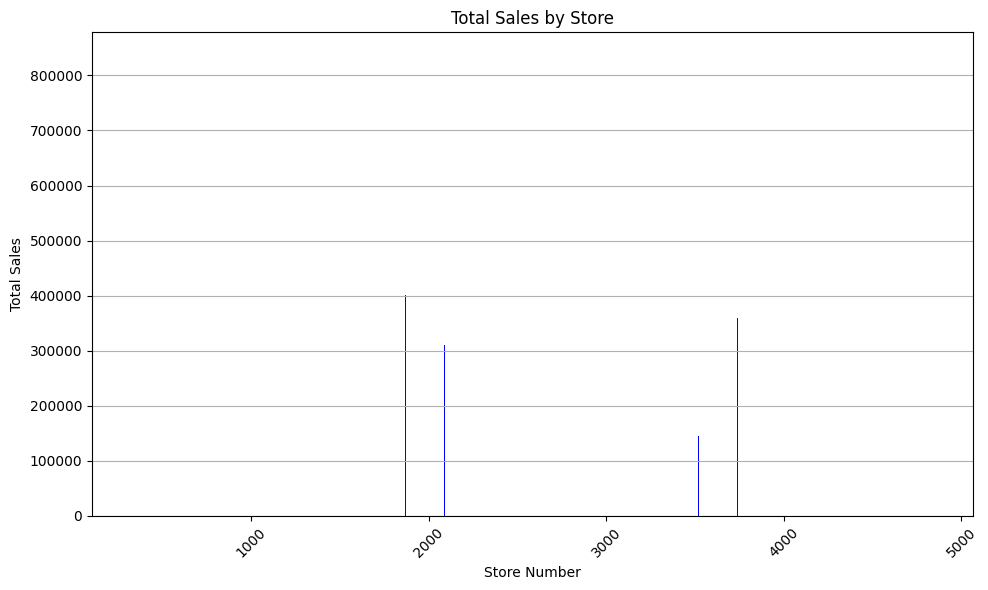

Processing questions:  40%|████      | 4/10 [00:32<01:07, 11.22s/it]

Starting router call span
Error processing question: Create a bar chart showing total sales by store
Object of type module is not JSON serializable
Starting main span with messages: [{'role': 'user', 'content': 'What percentage of items were sold on promotion?'}]
Running agent with messages: [{'role': 'user', 'content': 'What percentage of items were sold on promotion?'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span
Received response with tool calls: False
No tool calls, returning final response
Main span completed with return value: Approximately 62.56% of items were sold on promotion.


Processing questions:  50%|█████     | 5/10 [00:35<00:41,  8.26s/it]

Starting main span with messages: [{'role': 'user', 'content': 'Plot daily sales volume over time'}]
Running agent with messages: [{'role': 'user', 'content': 'Plot daily sales volume over time'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span


Processing questions:  60%|██████    | 6/10 [06:02<07:45, 116.48s/it]

Received response with tool calls: False
No tool calls, returning final response
Main span completed with return value: Here is the plot showing daily sales volume over time:

- The x-axis represents the date.
- The y-axis represents the daily sales volume.
- Daily sales figures illustrate fluctuations in sales volume across the specified time period.

If you need any further analysis or specific insights from this data, feel free to ask!
Starting main span with messages: [{'role': 'user', 'content': 'What was the average transaction value?'}]
Running agent with messages: [{'role': 'user', 'content': 'What was the average transaction value?'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span


Processing questions:  70%|███████   | 7/10 [06:05<03:57, 79.33s/it] 

Received response with tool calls: False
No tool calls, returning final response
Main span completed with return value: The average transaction value was approximately $19.02.
Starting main span with messages: [{'role': 'user', 'content': 'Create a box plot of transaction values'}]
Running agent with messages: [{'role': 'user', 'content': 'Create a box plot of transaction values'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span


Processing questions:  80%|████████  | 8/10 [06:14<01:53, 56.87s/it]

Error processing question: Create a box plot of transaction values
Error code: 400 - {'error': {'message': "Invalid 'messages[3].content': string too long. Expected a string with maximum length 1048576, but got a string with length 17447374 instead.", 'type': 'invalid_request_error', 'param': 'messages[3].content', 'code': 'string_above_max_length'}}
Starting main span with messages: [{'role': 'user', 'content': 'Which products were frequently purchased together?'}]
Running agent with messages: [{'role': 'user', 'content': 'Which products were frequently purchased together?'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span


Processing questions:  90%|█████████ | 9/10 [06:28<00:43, 43.65s/it]

Error processing question: Which products were frequently purchased together?
Error code: 400 - {'error': {'message': "Invalid 'messages[3].content': string too long. Expected a string with maximum length 1048576, but got a string with length 13390424 instead.", 'type': 'invalid_request_error', 'param': 'messages[3].content', 'code': 'string_above_max_length'}}
Starting main span with messages: [{'role': 'user', 'content': 'Plot a line graph showing the sales trend over time with a 7-day moving average'}]
Running agent with messages: [{'role': 'user', 'content': 'Plot a line graph showing the sales trend over time with a 7-day moving average'}]
Added system prompt to messages
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span
Received response with tool calls: True
Processing tool calls
Starting router call span
Received response with tool calls: False
No tool calls, returning final response


Processing questions: 100%|██████████| 10/10 [14:57<00:00, 89.71s/it] 

Main span completed with return value: Here's a line graph showing the sales trend over time along with a 7-day moving average. The blue line represents the total quantity sold, while the orange line shows the moving average, providing a clearer picture of the sales trends over the specified period.

![Sales Trend with 7-Day Moving Average](attachment://Sales_Trend_with_7_Day_Moving_Average.png)


In [18]:
agent_questions = [
    "What was the most popular product SKU?",
    "What was the total revenue across all stores?",
    "Which store had the highest sales volume?",
    "Create a bar chart showing total sales by store",
    "What percentage of items were sold on promotion?",
    "Plot daily sales volume over time", 
    "What was the average transaction value?",
    "Create a box plot of transaction values",
    "Which products were frequently purchased together?",
    "Plot a line graph showing the sales trend over time with a 7-day moving average"
]

for question in tqdm(agent_questions, desc="Processing questions"):
    try:
        ret = start_main_span([{"role": "user", "content": question}])
    except Exception as e:
        print(f"Error processing question: {question}")
        print(e)
        continue

# Evaluating the agent

In [20]:
OpenAIInstrumentor().uninstrument()

In [21]:
import phoenix as px
from phoenix.evals import (
    TOOL_CALLING_PROMPT_TEMPLATE, 
    llm_classify,
    OpenAIModel
)
from phoenix.trace import SpanEvaluations

from phoenix.experiments import evaluate_experiment
import nest_asyncio
nest_asyncio.apply()

In [22]:
px_client = px.Client()
eval_model = OpenAIModel(model="gpt-4o-mini")

/opt/anaconda3/envs/phoenix/lib/python3.11/site-packages/phoenix/utilities/client.py:34: UserWarning: The Phoenix server has an unknown version and may have compatibility issues.
  warnings.warn(


## Router Evals

In [23]:
import phoenix as px
from phoenix.trace.dsl import SpanQuery

query = SpanQuery().where(
    # Filter for the `RETRIEVER` span kind.
    # The filter condition is a string of valid Python boolean expression.
    "span_kind == 'LLM'",
).select(
    # Extract the span attribute `input.value` which contains the query for the
    # retriever. Rename it as the `input` column in the output dataframe.
    question="input.value",
    output_messages="llm.tools"
    
)

# The Phoenix Client can take this query and return the dataframe.
tool_calls_df = px.Client().query_spans(query, project_name=project_name, timeout=None)
tool_calls_df = tool_calls_df.dropna(subset=["output_messages"])
tool_calls_df["tool_call"] = tool_calls_df["output_messages"]

tool_calls_df.head()

/opt/anaconda3/envs/phoenix/lib/python3.11/site-packages/phoenix/utilities/client.py:54: UserWarning: The Phoenix server (7.7.1) and client (7.6.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


,question,output_messages,tool_call
context.span_id,,,
3987d5dccdbb9741,"{""messages"": [{""role"": ""user"", ""content"": ""Whi...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'tool': {'json_schema': '{""type"": ""function""..."
f503f8bc506307ce,"{""messages"": [{""role"": ""user"", ""content"": ""Whi...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'tool': {'json_schema': '{""type"": ""function""..."
4d0670e15d89edda,"{""messages"": [{""role"": ""user"", ""content"": ""Whi...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'tool': {'json_schema': '{""type"": ""function""..."
05066b669ea6b4b7,"{""messages"": [{""role"": ""user"", ""content"": ""Wha...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'tool': {'json_schema': '{""type"": ""function""..."
abc189ddd5d5a2ff,"{""messages"": [{""role"": ""user"", ""content"": ""Wha...","[{'tool': {'json_schema': '{""type"": ""function""...","[{'tool': {'json_schema': '{""type"": ""function""..."


In [ ]:
tool_call_eval = llm_classify(
    dataframe = tool_calls_df,
    template = TOOL_CALLING_PROMPT_TEMPLATE.template.replace("{tool_definitions}", "generate_visualization, lookup_sales_data, analyze_sales_data, run_python_code"),
    rails = ['correct', 'incorrect'],
    model=eval_model,
    provide_explanation=True
)

tool_call_eval['score'] = tool_call_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

tool_call_eval.head()

In [25]:
px.Client().log_evaluations(
    SpanEvaluations(eval_name="Tool Calling Eval", dataframe=tool_call_eval),
)

/opt/anaconda3/envs/phoenix/lib/python3.11/site-packages/phoenix/utilities/client.py:34: UserWarning: The Phoenix server has an unknown version and may have compatibility issues.
  warnings.warn(
/opt/anaconda3/envs/phoenix/lib/python3.11/site-packages/phoenix/utilities/client.py:54: UserWarning: The Phoenix server (7.7.1) and client (7.6.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


In [25]:
agent_tool_responses = {
    "What was the most popular product SKU?": "lookup_sales_data, analyze_sales_data",
    "What was the total revenue across all stores?": "lookup_sales_data, analyze_sales_data",
    "Which store had the highest sales volume?": "lookup_sales_data, analyze_sales_data",
    "Create a bar chart showing total sales by store": "generate_visualization, lookup_sales_data, run_python_code",
    "What percentage of items were sold on promotion?": "lookup_sales_data, analyze_sales_data",
    "Plot daily sales volume over time": "generate_visualization, lookup_sales_data, run_python_code", 
    "What was the average transaction value?": "lookup_sales_data, analyze_sales_data",
    "Create a box plot of transaction values": "generate_visualization, lookup_sales_data, run_python_code",
    "Which products were frequently purchased together?": "lookup_sales_data, analyze_sales_data",
    "Plot a line graph showing the sales trend over time with a 7-day moving average": "generate_visualization, lookup_sales_data, run_python_code"
}


tool_calling_df = pd.DataFrame(agent_tool_responses.items(), columns=["question", "tool_calls"])
dataset = px_client.upload_dataset(dataframe=tool_calling_df, dataset_name="tool_calling_ground_truth_live-2", input_keys=["question"], output_keys=["tool_calls"])

📤 Uploading dataset...
💾 Examples uploaded: https://app.phoenix.arize.com/datasets/RGF0YXNldDo2Nw==/examples
🗄️ Dataset version ID: RGF0YXNldFZlcnNpb246NzI=


## Tool Evals

### Evaluating our SQL generation tool

In [26]:
# Create a list of example user questions about sales data
db_lookup_questions = [
    "What was the most popular product SKU?",
    "Which store had the highest total sales value?", 
    "How many items were sold on promotion?",
    "What was the average quantity sold per transaction?",
    "Which product class code generated the most revenue?",
    "What day of the week had the highest sales volume?",
    "How many unique stores made sales?",
    "What was the highest single transaction value?",
    "Which products were frequently sold together?",
    "What's the trend in sales over time?"
]

expected_results = []

for question in tqdm(db_lookup_questions, desc="Processing SQL lookup questions"):
    try:
        expected_results.append(lookup_sales_data(question))
    except Exception as e:
        print(f"Error processing question: {question}")
        print(e)
        db_lookup_questions.remove(question)

# Create a DataFrame with the questions
questions_df = pd.DataFrame({
    'question': db_lookup_questions,
    'expected_result': expected_results
})

display(questions_df)

Processing SQL lookup questions: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


,question,expected_result
0,What was the most popular product SKU?,SKU_Coded Total_Qty_Sold\n0 6200700 ...
1,Which store had the highest total sales value?,Store_Number Total_Sales\n0 297...
2,How many items were sold on promotion?,Total_Items_Sold_On_Promo\n0 ...
3,What was the average quantity sold per transac...,Average_Quantity_Sold_Per_Transaction\n0 ...
4,Which product class code generated the most re...,Product_Class_Code Total_Revenue\n0 ...
5,What day of the week had the highest sales vol...,Day_Of_Week Total_Sales\n0 5 ...
6,How many unique stores made sales?,Unique_Stores\n0 35
7,What was the highest single transaction value?,Highest_Single_Transaction_Value\n0 ...
8,Which products were frequently sold together?,Product_A Product_B Frequency\n0 ...
9,What's the trend in sales over time?,Sold_Date Total_Qty_Sold Total_Sale_Val...


In [ ]:
dataset = px_client.upload_dataset(dataframe=questions_df, dataset_name="sales_db_lookup_questions_live-2", input_keys=["question"], output_keys=["expected_result"])

In [28]:
def evaluate_sql_result(output: str, expected: str) -> bool:
    output = output['messages'][0]['content']
    output = output.strip()
    output = output.replace("```sql", "").replace("```", "")
    result = str(duckdb.sql(output).df())
    
    # Extract just the numbers from both strings
    result_nums = ''.join(filter(str.isdigit, result))
    expected_nums = ''.join(filter(str.isdigit, expected.get("expected_result")))
    return result_nums == expected_nums

In [29]:
experiment_id = "RXhwZXJpbWVudDo5MA=="
experiment = px_client.get_experiment(experiment_id=experiment_id)
evaluators = [
    evaluate_sql_result
]

evaluate_experiment(
    experiment=experiment,
    evaluators=evaluators
)

🧠 Evaluation started.


running experiment evaluations |          | 0/8 (0.0%) | ⏳ 00:00<? | ?it/s

Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 
Failed to export batch code: 401, reason: 



🔗 View this experiment: https://app.phoenix.arize.com/datasets/RGF0YXNldDo2NQ==/compare?experimentId=RXhwZXJpbWVudDo5MA==

Experiment Summary (01/15/25 06:17 PM -0800)
--------------------------------------------
| evaluator           |   n |   n_scores |   avg_score |   n_labels | top_2_labels            |
|:--------------------|----:|-----------:|------------:|-----------:|:------------------------|
| evaluate_sql_result |   8 |          8 |       0.875 |          8 | {'True': 7, 'False': 1} |

Tasks Summary (01/15/25 06:17 PM -0800)
---------------------------------------
|   n_examples |   n_runs |   n_errors |
|-------------:|---------:|-----------:|
|            8 |        8 |          0 |


RanExperiment(id='RXhwZXJpbWVudDo5MA==', dataset_id='RGF0YXNldDo2NQ==', dataset_version_id='RGF0YXNldFZlcnNpb246NzA=', repetitions=1)

### Evaluating our Python code generation tool

In [ ]:
code_generation_questions = [
    "Create a bar chart showing total sales by store",
    "Plot daily sales volume over time", 
    "Plot a line graph showing the sales trend over time with a 7-day moving average",
    "Create a histogram of quantities sold per transaction",
    "Generate a pie chart showing sales distribution across product classes",
    "Create a stacked bar chart showing promotional vs non-promotional sales by store",
    "Generate a heatmap of sales by day of week and store number",
    "Plot a line chart comparing sales trends between top 5 stores"
]

example_data = []
chart_configs = []
for question in tqdm(code_generation_questions[:], desc="Processing code generation questions"):
    try:
        example_data.append(lookup_sales_data(question))
        chart_configs.append(json.dumps(extract_chart_config(example_data[-1], question)))
    except Exception as e:
        print(f"Error processing question: {question}")
        print(e)
        code_generation_questions.remove(question)

code_generation_df = pd.DataFrame({
    'question': code_generation_questions,
    'chart_configs': chart_configs
})

dataset = px_client.upload_dataset(dataframe=code_generation_df, dataset_name="code_generation_questions_live-2", input_keys=["question", "chart_configs"])

In [27]:
def code_is_runnable(output: str) -> bool:
    """Check if the code is runnable"""
    output = output['messages'][0]['content']
    output = output.strip()
    output = output.replace("```python", "").replace("```", "")
    try:
        exec(output)
        return True
    except Exception as e:
        return False


In [ ]:
experiment_id = "RXhwZXJpbWVudDo4Ng=="
experiment = px_client.get_experiment(experiment_id=experiment_id)
evaluators = [
    code_is_runnable
]

evaluate_experiment(
    experiment=experiment,
    evaluators=evaluators
)